# Classifying Business Documents using Deep Learning
## IBM Coursera Advanced Data Science Capstone

## Sumudu Tennakoon

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt 
from datetime import date
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
print('TensorFlow Version: ', tf.__version__)

from DocumentClassifierV1 import * #Custon utility library created for the project 

TensorFlow Version:  1.12.0


## 1. Read Pre-saved Input dataset

In [2]:
DocumentFilesData  = pd.read_pickle('Data/DocumentClassification_IBM_ADV_DS_Capstone_TrainSample_128x128_20190316.pkl')

## 2. Organize Classs Labels

In [3]:
ClassLabels = list(DocumentFilesData.FileClass.unique()) 

In [4]:
ClassNumbers = list(range(len(ClassLabels)))

In [5]:
ClassLabelMap = list((zip(ClassLabels, ClassNumbers)))
print(ClassLabelMap)

[('advertisement', 0), ('handwritten', 1), ('invoice', 2), ('letter', 3), ('resume', 4), ('scientific publication', 5)]


In [6]:
for clm in ClassLabelMap:
    DocumentFilesData.loc[DocumentFilesData['FileClass']==clm[0] , 'ClassNumber'] = clm[1]

## 3. Separate Features and Response

In [7]:
NClasses = len(ClassLabels)
imgRows = 128
imgCols = 128  

In [8]:
X = np.asarray(list(DocumentFilesData['DocumentMatrix'].values), dtype ='int')
y = DocumentFilesData['ClassNumber'].values

In [9]:
#Shape of datasets
print(X.shape)
print(y.shape)

(16256, 128, 128)
(16256,)


## 4. Plot sample image

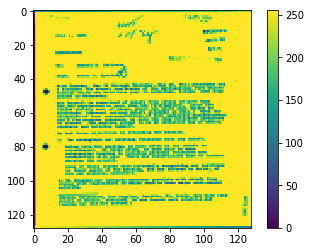

In [10]:
#Plot sample image with scale
plt.imshow(X[10000])
plt.colorbar()

## 5. Send data into the Model

In [11]:
if keras.backend.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, imgRows, imgCols)
    input_shape = (1, imgRows, imgCols)
else:
    X = X.reshape(X.shape[0], imgRows, imgCols, 1)
    input_shape = (imgRows, imgCols, 1)

In [12]:
X = X.astype('float32') #convert interger image tensor to float
X = X/255 # Normalize grayscale to a number between 0 and 1
print(X.shape[0], 'samples')
# Record actuals
y_act = y

16256 samples


In [13]:
y = keras.utils.to_categorical(y, NClasses)

In [14]:
ClassificationModel = TFModel(ModelFile='Models/DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316.pkl', Model=keras.models.load_model('Models/DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316.h5'))

In [15]:
Output = ClassificationModel.Classify(InputFiles=X, size=(imgRows,imgCols), ActualClasses=list(y_act),
                                      ReturnImageMatrix=True, ReturnJSON=False, ReturnFullPath=True, TransformedData=True)

## 6. Proces output

In [16]:
Output['actual'] = Output['actual'].astype('int')

In [17]:
for clm in ClassLabelMap:
    Output.loc[Output['actual']==clm[1] , 'actual'] = clm[0]

In [18]:
Output.head()

,filename,actual,prediction,probability,advertisement,handwritten,invoice,letter,resume,scientific publication,image
0,,advertisement,advertisement,1.000000,1.000000,2.048742e-11,1.044664e-12,4.011648e-15,1.974356e-19,2.601821e-14,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,,advertisement,advertisement,0.999992,0.999992,4.470792e-07,6.866239e-06,9.642420e-08,1.689488e-11,9.343865e-08,"[[0.63529414, 0.3372549, 0.29411766, 0.5764706..."
2,,advertisement,advertisement,1.000000,1.000000,2.330656e-22,1.572528e-19,2.069340e-23,1.100756e-29,2.149585e-21,"[[1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, ..."
3,,advertisement,invoice,0.904040,0.095956,3.059647e-08,9.040403e-01,3.450334e-06,1.438640e-10,1.550749e-07,"[[0.8039216, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1..."
4,,advertisement,advertisement,0.999833,0.999833,2.379422e-06,1.556897e-04,5.095118e-07,7.511499e-07,7.475842e-06,"[[0.52156866, 0.92156863, 0.92156863, 0.921568..."


### Confusion Matrix

In [19]:
cf = pd.crosstab(Output.actual, Output.prediction, margins=True)

In [20]:
cf

prediction,advertisement,handwritten,invoice,letter,resume,scientific publication,All
actual,,,,,,,
advertisement,2578,11,23,3,5,14,2634
handwritten,6,2572,22,11,2,5,2618
invoice,15,18,2734,42,9,11,2829
letter,5,12,67,2700,22,19,2825
resume,0,1,17,41,2625,12,2696
scientific publication,11,6,20,17,9,2591,2654
All,2615,2620,2883,2814,2672,2652,16256


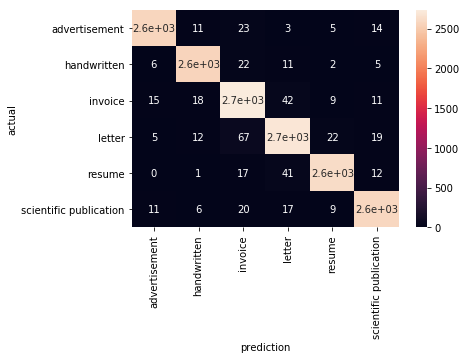

In [25]:
import seaborn as sns
sns.heatmap(pd.crosstab(Output.actual, Output.prediction, margins=False), annot=True)

## 7. Run the model on sample Image file


In [22]:
InputFiles = ['Data/test1.png']
Output_single = ClassificationModel.Classify(InputFiles=InputFiles, size=(imgRows,imgCols), ActualClasses=None,
                                  ReturnImageMatrix=True, ReturnJSON=True, ReturnFullPath=False, TransformedData=False)

In [23]:
Output_single

[{'filename': 'test1.png',
  'actual': None,
  'prediction': 'letter',
  'probability': 0.8929004,
  'classes': [{'class': 'advertisement', 'score': 2.2899491e-09},
   {'class': 'handwritten', 'score': 3.0054548e-07},
   {'class': 'invoice', 'score': 3.233218e-08},
   {'class': 'letter', 'score': 0.8929004},
   {'class': 'resume', 'score': 0.00031701275},
   {'class': 'scientific publication', 'score': 0.10678229}],
  'image': array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)}]

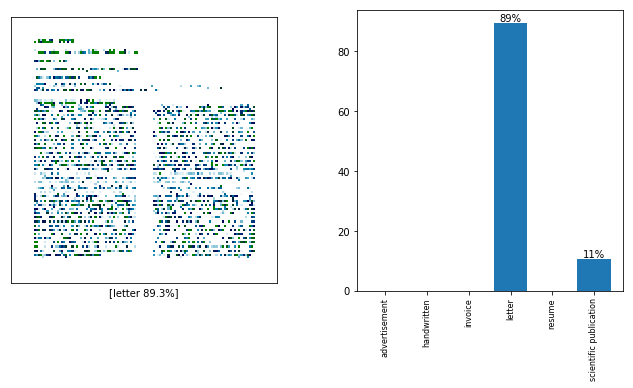

In [24]:
OutputDashboard = Dashboard()
fig = OutputDashboard.ImageOutput(Output_single, NSamples=1, Format='JSON', ClassLabels=ClassificationModel.ClassLabels)
plt.show()

<hr>
<p> This notebook and related materials were developed by <b> Sumudu Tennakoon</b> for the capstone project in partial fulfillment of the requirements for the <b> Advanced Data Science with IBM Specialization</b>. <br>
March 2019. <br>
Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)</p>
